<a href="https://colab.research.google.com/github/Kaiponbusters/githubpractice/blob/main/kNearest_Neighbor_clasifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# sklearnの準備

# irisデータセットの読み込み
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# データセットの分割（trainとtestに）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

# Xデータの標準化
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))  # 全体プロット用
y_combined = np.hstack((y_train, y_test))  # 全体プロット用

In [1]:
#決定領域を表示する関数

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    color=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]


        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100,
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100,
                        label='test set')

# k最近謗法(KNN)とは
**k最近謗法**とは、怠惰学習の代表的な例である。

**怠惰学習**とは、教師データから何かしらの方程式を生み出すのではなく、教師データを丸暗記する学習アルゴリズムのことである。

つまり、ロジスティック回帰を例に考えると**「新規データ新規データを分類するための重みの算出」**がロジスティック回帰であった。

これに対し、怠惰学習とは**「計算しないでデータを取り込むだけ」**のことである。


KNNのアルゴリズムは以下の手順にまとめられている。

```
1. kの値と距離指標を選択する
2. 分類したいデータ点からk個の最近傍のデータ点を見つけ出す
3. 多数決によりクラスラベルを割り当てる
```
KNNは、選択された距離指標に基づき、訓練データセットの中から分類したいデータ点に最も近いk個の訓練データを見つけ出す。データ店のクラスラベルは、k個の最近傍での多数決によって決まる。

このようなメモリベースのアプローチ(学習データをそのまま記憶して類似性を類推する方法)のメリットは、新しい訓練データを集めるとすぐに分類器がフィットすることである。

デメリットは、最悪の場合、新しいデータ点を分類する計算量が訓練データセットのデータ点の個数に比例して増加することである。

ただし、データセットの次元の個数が非常に少なく、KD木などのデータ構造を使って実装されていれば以上のデメリットが取り除かれる。

# KD木とは？

k-d木は任意の次元を持つ空間を分割する木構造である。

K-D木のアルゴリズムは、もともとの点群を二分木の構造に変換し、閾値を決めてクラスを分類するアルゴリズムである。

実際に、k-d木を実装してどのようなものかを確認してみる。
実装に関しては、[こちら](https://qiita.com/ttttpzm/items/fb2a1abf651ca8d417f0)を参考にして実装した。

In [4]:
import numpy as np
import matplotlib.pyplot as plt
"""
特定列を基準にソート
axis_xy : xなら0 yなら1
"""
def sortxy(arr:np.ndarray,axis_xy:int,offset:int = 0):
    axis = axis_xy + offset # offset
    return arr[np.argsort(arr[:,axis])]

# test
arr = np.array([[1000000,2,50],
               [2000000,0,100],
               [3000000,1,200]])
r = sortxy(arr,0)

#k-d木作成
offset = 0
x_col = 0 + offset
y_col = 1 + offset
class Node:
    def set_node(self,points:np.ndarray,right:int,depth:int):
        if right < 0:
            return None
        elif right == 0:
            return self.set_leaf(points[right],depth)

        axis = depth % 2
        sorted_points = sortxy(points[:right + 1],axis)
        if axis == 0:
            self.left_most = sorted_points[0][x_col]
            self.right_most = sorted_points[right][x_col]
        else:
            self.bottom_most = sorted_points[0][y_col]
            self.top_most = sorted_points[right][y_col]
        median = int(right / 2)
        self.border = (sorted_points[median][x_col:] + sorted_points[median+1][x_col:])/2.0
        self.location = sorted_points[median]
        self.depth = depth
        self.right_child = Node().set_node(sorted_points[median
                                                          + 1:],right -( median + 1),depth + 1)
        self.left_child = Node().set_node(sorted_points,median,depth + 1)

        #ここから先は関連付け
        if(axis == 0):
            if(not(self.right_child is None) and not(self.left_child is None)):
                self.top_most = self.right_child.top_most if self.right_child.top_most > self.left_child.top_most else self.left_child.top_most
                self.bottom_most = self.right_child.bottom_most if self.right_child.bottom_most < self.left_child.bottom_most else self.left_child.bottom_most
            elif not(self.right_child is None):
                self.top_most = self.right_child.top_most
                self.bottom_most = self.right_child.bottom_most
            elif not(self.left_child is None):
                self.top_most = self.left_child.top_most
                self.bottom_most = self.left_child.bottom_most
            else:
                self.top_most = self.location[y_col]
                self.bottom_most = self.location[y_col]
        else:
            if(not(self.right_child is None) and not(self.left_child is None)):
                self.right_most = self.right_child.right_most if self.right_child.right_most > self.left_child.right_most else self.left_child.right_most
                self.left_most = self.right_child.left_most if self.right_child.left_most < self.left_child.left_most else self.left_child.left_most
            elif not(self.right_child is None):
                self.right_most = self.right_child.right_most
                self.left_most = self.right_child.left_most
            elif not(self.left_child is None):
                self.right_most = self.left_child.right_most
                self.left_most = self.left_child.left_most
            else:
                self.right_most = self.location[x_col]
                self.left_most = self.location[x_col]

        return self
    def set_leaf(self,location:np.ndarray,depth:int):
        self.location = location
        self.left_child = None
        self.right_child = None
        self.depth = depth
        self.left_most = location[x_col]
        self.right_most = location[x_col]
        self.top_most = location[y_col]
        self.bottom_most = location[y_col]
        return self
    def is_contained(self,sx:int,tx:int,sy:int,ty:int):
        """
        > regionノードから始まるsubtreeの要素が指定領域にすっぽり収まっているか否かを返す。
        > 各ノードに、自分以下の子の最大、最小値をもたせているので、それを参照するだけで判定できる。
        実装参考のis_contained関数より引用
        """
        return not(self.left_most < sx or self.right_most > tx or self.top_most > ty or self.bottom_most < sy)
class Tree:
    def build(self,points):
        node = Node().set_node(points,len(points) - 1,0)
        self.top_node = node
        return node
    def search(self,sx:int,tx:int,sy:int,ty:int):
        search_results = []
        def _search(v:Node):
            nonlocal search_results,sx,tx,sy,ty
            if v.right_most < sx or v.left_most > tx or v.bottom_most > ty or v.top_most < sy:
                return;
            if v.left_child is None and v.right_child is None:
                if sx <= v.location[x_col] and sy <= v.location[y_col] and tx >= v.location[x_col] and ty >= v.location[y_col]:
                    self.search_results.append(v.location)
                    return
            if not(v.left_child is None):
                if(v.left_child.is_contained(sx,tx,sy,ty)):
                    search_results += self.report_subtree(v.left_child)
                else:
                    _search(v.left_child)
            if not(v.right_child is None):
                if(v.right_child.is_contained(sx,tx,sy,ty)):
                    search_results += self.report_subtree(v.right_child)
                else:
                    _search(v.right_child)
        _search(self.top_node)
        return search_results
    def report_subtree(self,node:Node = None,parent:Node=None,parent_border_axis:tuple = None,draw_border:tuple = None):
        """
        draw_border:tuple = (max_x,min_x,max_y,min_y)
        """
        if node is None:
            node = self.top_node
        if node.left_child is None and node.right_child is None:
            return [node.location]
        pba = parent_border_axis
        if not (draw_border is None) :
            xmax,xmin,ymax,ymin = draw_border
            s = node.border.copy()
            e = [0,0]
            if parent is None:
                s[1] = ymax
                e = np.array([s[0],ymin])
                pba = (s[0],None)
            else:
                if pba[0] is None:
                    y = ymax if(pba[1] < s[1]) else ymin
                    s[1] = pba[1]
                    e = np.array([s[0],y])
                    pba = (s[0],None)
                else: #つまり親がy軸と並行
                    x = xmax if(pba[0] < s[0]) else xmin
                    s[0] = pba[0]
                    e = np.array([x,s[1]])
                    pba = (None,s[1])
            plt.plot([s[0],e[0]],[s[1],e[1]])
        arr = []
        if not (node.left_child is None):
            arr += self.report_subtree(node.left_child,node,pba,draw_border)
        if not (node.right_child is None):
            arr += self.report_subtree(node.right_child,node,pba,draw_border)
        return arr

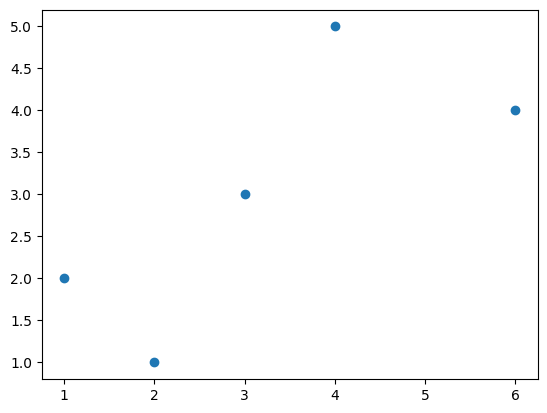

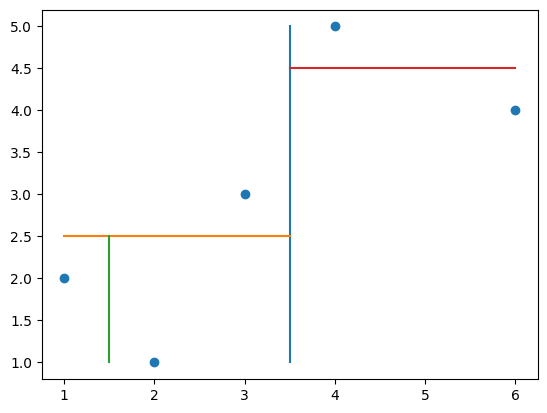

In [12]:
# test
points = [
    [1,2],
    [2,1],
    [4,5],
    [6,4],
    [3,3],
]
points = np.array(points)
tree = Tree()
node = tree.build(points)
plt.scatter(points[:,x_col],points[:,y_col])
plt.show()
plt.scatter(points[:,x_col],points[:,y_col])
tree.report_subtree(draw_border=(points[:,x_col].max(),points[:,x_col].min(),points[:,y_col].max(),points[:,y_col].min()))
plt.show()

以上のように、２次元データに関しては空間が区切られた。

データ点には、[1,2],
    [2,1],
    [4,5],
    [6,4],
    [3,3]
    の５点を用意した。

k-d木は、それぞれの軸の中央値を取ることで作ることができる。
そのため、まずはX軸を左から見て3番目と4番目のデータ点の間を分割する。その後は、この分割線より左側にある3点をy軸で見たときの中央値を分割する。

そして、最初に分割した線より右側の二点をy軸で見て、中央値で分割する。
最後に、黄色線の下にデータ点が２つあるので、この中央値で分割する。

こうして、空間が区切られた。このようにしてk-d木のアルゴリズムが成り立っていることがわかった。

では、ユークリッド距離(三平方の定理を適用して求めた最短距離)の指標を使ってsklearnでKNNモデルを実装する。

<ipython-input-1-5cc7471b6730>:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
<ipython-input-1-5cc7471b6730>:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


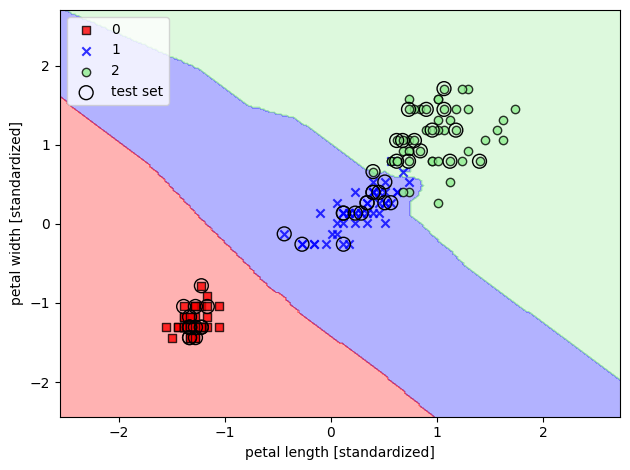

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5,
                           p=2,
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()

では、

```
knn = KNeighborsClassifier(n_neighbors=5,
                           p=2,
                           metric='minkowski')
```

のパラメータを変更して、他の距離指標に基づいた出力も確認してみる。
p=1の場合はマンハッタン距離(L1ノルム/格子状に移動した時の距離)
p>=3の任意のpに関しては、ミンコフスキー距離が用いられる。



<ipython-input-1-5cc7471b6730>:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
<ipython-input-1-5cc7471b6730>:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


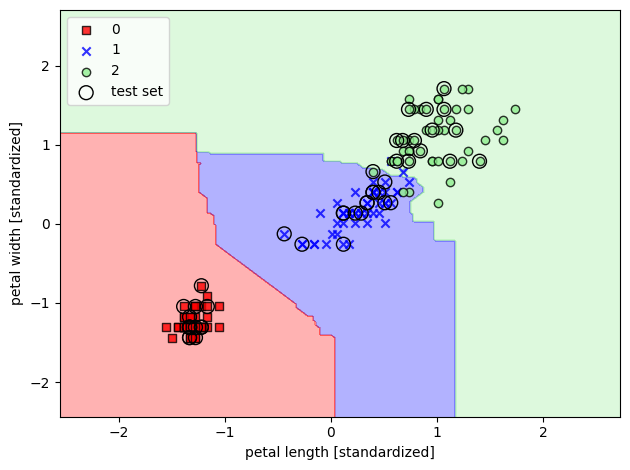

In [13]:
knn = KNeighborsClassifier(n_neighbors=5,
                           p=1,
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()

p=2^10で試す

<ipython-input-1-5cc7471b6730>:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
<ipython-input-1-5cc7471b6730>:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


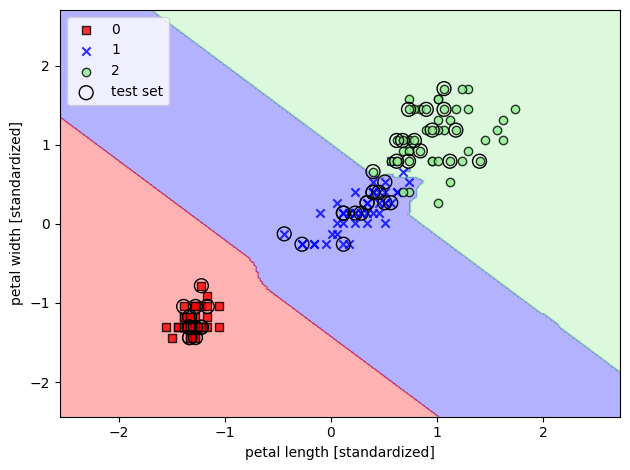

In [16]:
knn = KNeighborsClassifier(n_neighbors=5,
                           p=2^10,
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()